# Pulse Nulling: Example Notebook

This notebook will serve as an example of how to use the pulse nulling feature of the `Pulse Signal Simulator`. 

In [1]:
# Start by importing the packages we will need for the simulation.
import psrsigsim as pss 

# Additional necessary packages
import numpy as np
import matplotlib.pyplot as plt
# helpful magic lines
%matplotlib inline

We define a plotting convenience function for later.

In [2]:
# Define a function for easier plotting later on/throughout the testing
def plotsignal(signals, nbins=2048):
    # signals can be a list of multiple signals to overplot
    for ii in range(len(signals)):
        # Define the x axis
        phases = np.linspace(0.0, len(signals[ii]), len(signals[ii]))/nbins
        # now plot it
        plt.plot(phases, signals[ii], label="signal %s" % (ii))
    plt.xlim([0.0, np.max(phases)])
    plt.xlabel("Pulse Phase")
    plt.ylabel("Arb. Flux")
    plt.show()
    plt.close()

Now we will define some example simulation parameters. The warning generated below may be ignored.

In [3]:
# define the required filterbank signal parameters
f0 = 1380 # center observing frequecy in MHz
bw = 800.0 # observation MHz
Nf = 2 # number of frequency channels
F0 = np.double(1.0) # pulsar frequency in Hz
f_samp = F0*2048*10**-6 # sample rate of data in MHz, here 2048 bins across the pulse
subintlen = 1.0 # desired length of fold-mode subintegration in seconds
# Now we define our signal
null_signal = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf,\
                                          sample_rate=f_samp, fold=True, sublen=subintlen)

Now we define an example Gaussian pulse shape. Details on defining a pulse shape from a data array may be found in the example notebook in the docs.

In [4]:
prof = pss.pulsar.GaussProfile(peak=0.5, width=0.05, amp=1.0)

Now we define an example pulsar.

In [5]:
# Define the necessary parameters
period = np.double(1.0)/F0 # seconds
flux = 0.1 # Jy
psr_name = "J0000+0000"
# Define the pulsar object
pulsar = pss.pulsar.Pulsar(period=period, Smean=flux, profiles=prof, name=psr_name)

Now we actually make the pulsar signal. Note that if the observation length is very long all the data will be saved in memory which may crash the computer or slow it down significantly.

In [6]:
# Define the observation time, in seconds
ObsTime = 3.0 # seconds
# make the pulses
pulsar.make_pulses(null_signal, tobs = ObsTime)

Now let's take a look at what the signals look like.

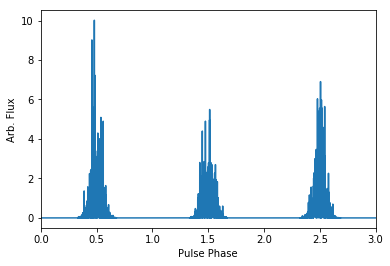

In [7]:
# We plot just the first frequency channel, but all pulses simulated
plotsignal([null_signal.data[0,:]])

Now we can disperse the simuated data if desired. Note that this is not required, and if you only want to simulate a single frequency channel or simulate coherently dedispersed data, the data does not have to be dispersed.

100% dispersed in 0.001 seconds.

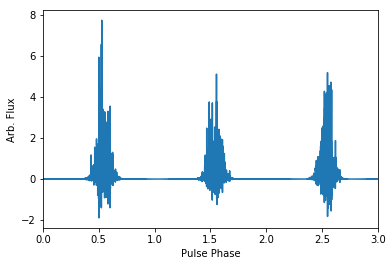

In [8]:
# First define the dispersion measure
dm = 10.0 # pc cm^-3
# Now define the ISM class
ism_ob = pss.ism.ISM()
# Now we give the ISM class the signal and disperse the data
ism_ob.disperse(null_signal, dm)
# If we plot the same pulses as above, you can see that the phase of the pulse has
# been shfited due to the dispersion
plotsignal([null_signal.data[0,:]])

This is where the pulses should be nulled if desired. This can be run easily by giving the pulsar object only the signal class and the null fraction as a value between 0 and 1. The simulator will null as close to the null fraction as desired, and will round to the closest integer number of pulses to null based on the input nulling fraction, e.g. if 5 pulses are simulated and the nulling fraction is 0.5, it will round to null 3 pulses. Additionally, currently only the ability to null the pulses randomly is implemented. 

Here we will put in a nulling fraction of 33%.

In [9]:
pulsar.null(null_signal, 0.34)

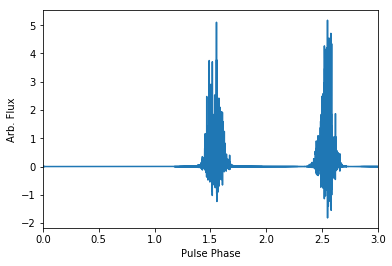

In [10]:
# and plot the signal to show the null
plotsignal([null_signal.data[0,:]])

We can also add radiometer noise from some observing telescope. This should only be run AFTER the pulsar nulling, but is not required. For our example, we will use the L-band feed for the Arecibo telescope. Note that here since we have set the pulsar flux very high we can easily see the single pulses above the noise.

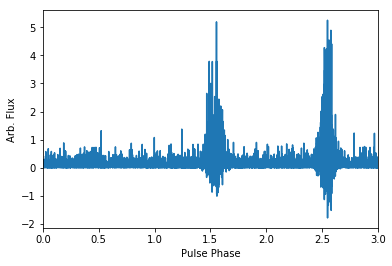

In [11]:
# We define the telescope object
tscope = pss.telescope.telescope.Arecibo()
# Now add radiometer noise; ignore the output here, the noise is added directly to the signal
output = tscope.observe(null_signal, pulsar, system="Lband_PUPPI", noise=True)
# and plot the signal to show the added noise
plotsignal([null_signal.data[0,:]])

Now we can save the data in a `PSRCHIVE pdv` format. This is done with the `txtfile` class. The save function will dump a new file for every 100 pulses that it writes to the text file. We start by initializing the `txtfile` object. The only input needed here is the `path` variable, which will tell the simulator where to save the data. All files saved will have "_\#.txt" added to the end of the `path` variable.

In [12]:
txtfile = pss.io.TxtFile(path="PsrSigSim_Simulated_Pulsar.ar")
# Now we call the saving function. Note that depending on the length of the simulated data this may take awhile
# the two inputs are the signal and the pulsar objects used to simulate the data.
txtfile.save_psrchive_pdv(null_signal, pulsar)

And that's all that there should be to it. Let us know if you have any questions moving forward, or if something is not working as it should be.

### Note about randomly generated pulses and noise

`PsrSigSim` uses `numpy.random` under the hood in order to generate the radio pulses and various types of noise. If a user desires or requires that this randomly generated data is reproducible we recommend using a call the seed generator native to `Numpy` before calling the function that produces the random noise/pulses. Newer versions of `Numpy` are moving toward slightly different [functionality/syntax](https://numpy.org/doc/stable/reference/random/index.html), but is essentially used in the same way. 
```
numpy.random.seed(1776)
pulsar_1.make_pulses(signal_1, tobs=obslen)

```